In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import ase 
from ase.units import Bohr 
import torch
import metatensor
from metatensor import TensorMap, TensorBlock, Labels
import matplotlib.pyplot as plt
from ase.io import read 
import hickle
from mlelec.utils.metatensor_utils import labels_where

from mlelec.data.dataset import PeriodicDataset

/home/nigam/miniconda3/lib/python3.11/site-packages/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [4]:
filename = "C2_rotated"
frames = read('examples/data/periodic/c2/C2_rotated.xyz', ':') # will be automated from filename  
for f in frames:
    f.pbc = [True, True, True]
kfock = np.load('examples/data/periodic/c2/results_{}/kfocks.npy'.format(filename))
rotated_dataset = PeriodicDataset(frames = frames, kgrid=[4,4,1], matrices_kpoint = kfock, target=["real_translation"] ,device = "cpu")#, desired_shifts=desired_shifts)

In [5]:
rotated_dataset.desired_shifts

[[1, 1, 0],
 [1, -2, 0],
 [1, -1, 0],
 [1, 0, 0],
 [-2, 1, 0],
 [-2, -2, 0],
 [-2, -1, 0],
 [-2, 0, 0],
 [-1, -2, 0],
 [0, 1, 0],
 [0, -2, 0],
 [0, 0, 0]]

In [6]:
## This should happen in the ML Dataset class #TODO
## Fix orbital order 
from mlelec.utils.twocenter_utils import fix_orbital_order
orbs = {6: [[1,0,0],[2,0,0],[2,1,1], [2,1,-1],[2,1,0]]}
for T in rotated_dataset.matrices_translation.keys():
    rotated_dataset.matrices_translation[T] = fix_orbital_order(rotated_dataset.matrices_translation[T], frames, orbs)


In [14]:
withnegative_shifts = list(rotated_dataset.desired_shifts_sup.keys())
# withnegative_shifts.remove((0,0,0))
desired_shifts = list(rotated_dataset.desired_shifts)
desired_shifts.remove([0,0,0]) # for now we remove the zero shift until i have incorporate featuires for zero shift into the feats 

## Matrix to blocks 

In [7]:
from mlelec.utils.twocenter_utils import _to_blocks, _to_matrix, _to_coupled_basis, _to_uncoupled_basis, discard_nonhermiticity

In [8]:
# Extracting matrices out from the dataset for now 
matrices = {}
for s in rotated_dataset.desired_shifts[:]: # positive translations only 
    matrices[tuple(s)] = torch.from_numpy(rotated_dataset.matrices_translation[tuple(s)]).to('cuda')
    # NORMALIZING the translated matrices for each structure - not sure this is for training - SKIP if not needed
    # matrices[tuple(s)] = matrices[tuple(s)]/torch.linalg.norm(matrices[tuple(s)], axis = (1,2) ) [:,None, None]


In [9]:
target_blocks = {}
target_blocks = {}
target_coupled_blocks = {}
for s in desired_shifts[:]:
    target_blocks[tuple(s)] = _to_blocks(matrices[tuple(s)], frames=frames, orbitals=orbs, NH=True) # matrix -> uncoupled
    # Dont forget NH = True
    target_coupled_blocks[tuple(s)] = _to_coupled_basis(target_blocks[tuple(s)], orbs, skip_symmetry=True) # uncouple -> coupled
    # Dont forget skip_symmetry = True

/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/my_mlelec/src/mlelec/utils/twocenter_utils.py:162: UserWarning: Matrix is neither hermitian nor antihermitian - attempting to use _toblocks for NH
  warnings.warn(
/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/my_mlelec/src/mlelec/utils/metatensor_utils.py:129: DeviceWarning: Values and labels for this block are on different devices: labels are always on CPU, and values are on device 'cuda:0'. If you are using PyTorch and need the labels to also be on cuda:0, you should use `metatensor.torch.TensorBlock`.
  block = TensorBlock(
/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/my_mlelec/src/mlelec/utils/metatensor_utils.py:91: DeviceWarning: Blocks values and keys for this TensorMap are on different devices: keys are always on CPU, and blocks values are on device 'cuda:0'. If you are using PyTorch and need the labels to also be on cuda:0, you should use `metatensor.torch.TensorMap`.
  return TensorMap(keys, blocks)


In [10]:
from collections import defaultdict
blocks = []
tmap_keys = []
for translation in target_coupled_blocks.keys():
    for i, (key, block) in enumerate(target_coupled_blocks[translation].items()):
        blocks.append(block.copy())
        x = list(key)
        x.extend(translation)
        tmap_keys.append(x)
keys = Labels(next(iter(target_coupled_blocks.values())).keys.names+["cell_shift_a", "cell_shift_b", "cell_shift_c"], values=np.asarray(tmap_keys))
target = TensorMap(keys=keys, blocks=blocks)

target = target.keys_to_samples('cell_shift_a')
target = target.keys_to_samples('cell_shift_b')
target = target.keys_to_samples('cell_shift_c')


/tmp/ipykernel_218761/3725357898.py:11: DeviceWarning: Blocks values and keys for this TensorMap are on different devices: keys are always on CPU, and blocks values are on device 'cuda:0'. If you are using PyTorch and need the labels to also be on cuda:0, you should use `metatensor.torch.TensorMap`.
  target = TensorMap(keys=keys, blocks=blocks)


## feature

In [11]:
from mlelec.utils.metatensor_utils import labels_where
from metatensor import Labels
from mlelec.features.acdc import twocenter_hermitian_features, single_center_features, pair_features, twocenter_hermitian_features_periodic
from mlelec.utils.twocenter_utils import map_targetkeys_to_featkeys
from mlelec.features.acdc import twocenter_features_periodic_NH
from mlelec.features.acdc_utils import _pca 



In [12]:
hypers = {'cutoff': 4,
          'max_radial':8, 
          'max_angular':4,
          'atomic_gaussian_width':0.3,
          'center_atom_weight':1,
          "radial_basis": {"Gto": {}},
          "cutoff_function": {"ShiftedCosine": {"width": 0.1}},
}

In [13]:
# two center features used for all translations except the 0,0,0 translation
rhoij = pair_features(frames, hypers, order_nu=[1,1],  all_pairs=True, lcut=2, max_shift=[2,3,1], both_centers=True,)# device = "cpu")

/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/my_mlelec/src/mlelec/features/acdc.py:132: UserWarning: Using cutoff 7.0 for all pairs feature
  warnings.warn(
/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/my_mlelec/src/mlelec/features/acdc_utils.py:614: DeviceWarning: Values and labels for this block are on different devices: labels are always on CPU, and values are on device 'cuda:0'. If you are using PyTorch and need the labels to also be on cuda:0, you should use `metatensor.torch.TensorBlock`.
  newblock = TensorBlock(
/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/my_mlelec/src/mlelec/features/acdc_utils.py:624: DeviceWarning: Blocks values and keys for this TensorMap are on different devices: keys are always on CPU, and blocks values are on device 'cuda:0'. If you are using PyTorch and need the labels to also be on cuda:0, you should use `metatensor.torch.TensorMap`.
  X = TensorMap(


In [15]:
blocks = []
# normalizing features - SKIP if needed 
# rhoij_norm = {tuple(t):[] for t in desired_shifts}
# for i, (k,b) in enumerate(rhoij.items()):
#       for t in desired_shifts[:]:
#             tlab, tidx = labels_where(b.samples, selection=Labels(names=["cell_shift_a", "cell_shift_b", "cell_shift_c"], values=np.array([t]).reshape(1,3)), return_idx=True)
#             rhoij_norm[tuple(t)].append(torch.linalg.norm(b.values[tidx])**2)

# for t in desired_shifts:
#       rhoij_norm[tuple(t)] =torch.sum(torch.tensor(rhoij_norm[tuple(t)])) 

for i, (k,b) in enumerate(rhoij.items()):
      # tlab, tidx = labels_where(b.samples, selection=Labels(names=["cell_shift_a", "cell_shift_b", "cell_shift_c"], values=np.array([t]).reshape(1,3)), return_idx=True)

      # b.values[tidx] = b.values[tidx]/torch.sqrt(rhoij_norm[tuple(t)]+1e-6) # dividing by norm of features, SKIP if needed 

      slab, sidx = labels_where(b.samples, selection=Labels(names=["cell_shift_a", "cell_shift_b", "cell_shift_c"], values=np.array(desired_shifts[:]).reshape(-1,3)), return_idx=True) # only retain tranlsations that we want - DONT SKIP 


      blocks.append(TensorBlock(values = b.values[sidx],
                              components = b.components,
                        samples = Labels(names = b.samples.names, values=np.asarray(b.samples.values[sidx])),
                              properties = b.properties)
                        )
rhoij = TensorMap(keys=rhoij.keys, blocks=blocks)
        
# One can PCA the features if desired 
# rhoij_pca = _pca(rhoij)

/tmp/ipykernel_218761/1895663004.py:20: DeviceWarning: Values and labels for this block are on different devices: labels are always on CPU, and values are on device 'cuda:0'. If you are using PyTorch and need the labels to also be on cuda:0, you should use `metatensor.torch.TensorBlock`.
  blocks.append(TensorBlock(values = b.values[sidx],
/tmp/ipykernel_218761/1895663004.py:25: DeviceWarning: Blocks values and keys for this TensorMap are on different devices: keys are always on CPU, and blocks values are on device 'cuda:0'. If you are using PyTorch and need the labels to also be on cuda:0, you should use `metatensor.torch.TensorMap`.
  rhoij = TensorMap(keys=rhoij.keys, blocks=blocks)


In [16]:
hfeat = twocenter_features_periodic_NH(single_center=None, pair= rhoij) # take the pair feature and create features corresponding to different blocks of the hamiltonian 

/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/my_mlelec/src/mlelec/features/acdc.py:344: DeviceWarning: Values and labels for this block are on different devices: labels are always on CPU, and values are on device 'cuda:0'. If you are using PyTorch and need the labels to also be on cuda:0, you should use `metatensor.torch.TensorBlock`.
  TensorBlock(
/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/my_mlelec/src/mlelec/features/acdc.py:398: DeviceWarning: Values and labels for this block are on different devices: labels are always on CPU, and values are on device 'cuda:0'. If you are using PyTorch and need the labels to also be on cuda:0, you should use `metatensor.torch.TensorBlock`.
  TensorBlock(
/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/my_mlelec/src/mlelec/features/acdc.py:409: DeviceWarning: Values and labels for this block are on different devices: labels are always on CPU, and values are on device 'cuda:0'. If you are using PyTorch and need the labels t

In [17]:
rhonui = single_center_features(frames, hypers, order_nu=3, lcut=2, max_shift=[2,3,1], feature_names = hfeat.property_names)
rhoij_zero_shift = pair_features(frames, hypers, order_nu=[1,1],  both_centers=True, all_pairs=True, lcut=2, max_shift=[1,1,1], feature_names = rhonui.property_names)
# pair = rhoij
blocks = []
for i, (key, block) in enumerate(rhoij_zero_shift.items()):
    samples_lab, idx = labels_where(block.samples, selection=Labels(["cell_shift_a", "cell_shift_b", "cell_shift_c"], values=np.asarray([[0,0,0]]).reshape(-1, 3)), return_idx=True)
    samples_lab =  Labels(samples_lab.names[:3], values=samples_lab.values[:,:3])
    tb = TensorBlock(
        samples=samples_lab,
        values=block.values[idx],
        properties=block.properties,
        components = block.components
    )
    blocks.append(tb)
rhoij_zero_shift = TensorMap(keys = rhoij_zero_shift.keys, blocks=blocks)
hfeat0 = twocenter_features_periodic_NH(single_center= rhonui, pair = rhoij_zero_shift, shift=[0,0,0]) # take the pair feature and create features corresponding to different blocks of the hamiltonian
hfeat0 = hfeat0.keys_to_samples('cell_shift_a')
hfeat0 = hfeat0.keys_to_samples('cell_shift_b')
hfeat0 = hfeat0.keys_to_samples('cell_shift_c')


/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/my_mlelec/src/mlelec/features/acdc.py:132: UserWarning: Using cutoff 2.0 for all pairs feature
  warnings.warn(
/tmp/ipykernel_218761/2812144406.py:8: DeviceWarning: Values and labels for this block are on different devices: labels are always on CPU, and values are on device 'cuda:0'. If you are using PyTorch and need the labels to also be on cuda:0, you should use `metatensor.torch.TensorBlock`.
  tb = TensorBlock(


HERE


/tmp/ipykernel_218761/2812144406.py:15: DeviceWarning: Blocks values and keys for this TensorMap are on different devices: keys are always on CPU, and blocks values are on device 'cuda:0'. If you are using PyTorch and need the labels to also be on cuda:0, you should use `metatensor.torch.TensorMap`.
  rhoij_zero_shift = TensorMap(keys = rhoij_zero_shift.keys, blocks=blocks)
/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/my_mlelec/src/mlelec/features/acdc.py:245: DeviceWarning: Values and labels for this block are on different devices: labels are always on CPU, and values are on device 'cuda:0'. If you are using PyTorch and need the labels to also be on cuda:0, you should use `metatensor.torch.TensorBlock`.
  TensorBlock(
/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/my_mlelec/src/mlelec/features/acdc.py:290: DeviceWarning: Values and labels for this block are on different devices: labels are always on CPU, and values are on device 'cuda:0'. If you are using PyTorch and n

In [18]:
hfeat0.property_names == hfeat.property_names

True

In [19]:
from metatensor.operations import join 
hfeat = join([hfeat, hfeat0],axis="properties")

/home/nigam/miniconda3/lib/python3.11/site-packages/metatensor/operations/join.py:301: DeviceWarning: Values and labels for this block are on different devices: labels are always on CPU, and values are on device 'cuda:0'. If you are using PyTorch and need the labels to also be on cuda:0, you should use `metatensor.torch.TensorBlock`.
  new_block = TensorBlock(
/home/nigam/miniconda3/lib/python3.11/site-packages/metatensor/operations/join.py:326: DeviceWarning: Blocks values and keys for this TensorMap are on different devices: keys are always on CPU, and blocks values are on device 'cuda:0'. If you are using PyTorch and need the labels to also be on cuda:0, you should use `metatensor.torch.TensorMap`.
  tensor = TensorMap(keys=keys, blocks=blocks)


## train

In [20]:
from mlelec.models.linear import LinearModelPeriodic
from mlelec.utils.plot_utils import plot_hamiltonian 

In [22]:
target[0].samples.values.shape, hfeat[0].samples.values.shape

((72, 6), (72, 6))

In [25]:
model = LinearModelPeriodic(hfeat, target, frames, orbs,
                            cell_shifts= rotated_dataset.desired_shifts[:], 
                            nhidden=16, nlayers=2)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# optimizer= torch.optim.SGD(model.parameters(), lr=1e-3)
# optimizer = torch.optim.LBFGS(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=100, verbose=True)


def train(model, target_blocks, nepochs=10, optimizer=None, scheduler=None, log_interval=10):
    losses = []
    for i in range(nepochs):
        # def closure():
        #     optimizer.zero_grad()
        #     rmat = model.forward()
        #     loss = 0
        #     for s in rmat:            
        #         loss += torch.linalg.norm(rmat[s]-matrices[tuple(s)])**2
        #     # loss = torch.linalg.norm(rmat - matrices)**2
        #     # loss.backward()
        #     return loss

        # optimizer.step(closure)
        # loss = closure()

    #---ADAM---- 
        optimizer.zero_grad()
        rmat = model.forward()
        loss = 0
        for s in rmat:      
            for (key, block) in rmat[s].items():
                loss += torch.linalg.norm(block.values-target_blocks[tuple(s)].block(key).values)**2      
            # loss += torch.sum((rmat[s]-matrices[tuple(s)])**2)


        loss.backward()
        optimizer.step()
        # scheduler.step(loss)
        losses.append(loss.item())
        if i%log_interval ==0:
            print(i, loss.item())
    return losses, model, optimizer


[[1, 1, 0], [1, -2, 0], [1, -1, 0], [1, 0, 0], [-2, 1, 0], [-2, -2, 0], [-2, -1, 0], [-2, 0, 0], [-1, -2, 0], [0, 1, 0], [0, -2, 0], [0, 0, 0]] 12


In [27]:
losses, model, optimizer = train(model, target_coupled_blocks, nepochs=2000, optimizer=optimizer)

0 0.0017503242706879973
10 0.0018151219701394439
20 0.0017396773910149932
30 0.0018684456590563059
40 0.001681140041910112
50 0.00164368178229779
60 0.00163083930965513
70 0.0015999069437384605
80 0.0015761853428557515
90 0.0015561890322715044
100 0.0015419040573760867
110 0.0017378696938976645
120 0.0015758720692247152
130 0.0015651609282940626
140 0.0028784102760255337
150 0.0016673019854351878
160 0.0014649612130597234
170 0.0014152214862406254
180 0.0013902579667046666
190 0.001374551560729742
200 0.0013600913807749748
210 0.0013397824950516224
220 0.001326170051470399
230 0.0013066146057099104
240 0.0012992577394470572
250 0.0012790273176506162
260 0.001262590754777193
270 0.0012443746672943234
280 0.0012369112810119987
290 0.0012382029090076685
300 0.0012149021495133638
310 0.0012159771285951138
320 0.0011900829849764705
330 0.0011772013967856765
340 0.0011727316305041313
350 0.0011354292510077357
360 0.0012393638025969267
370 0.00326179969124496
380 0.0017214989056810737
390 0.0

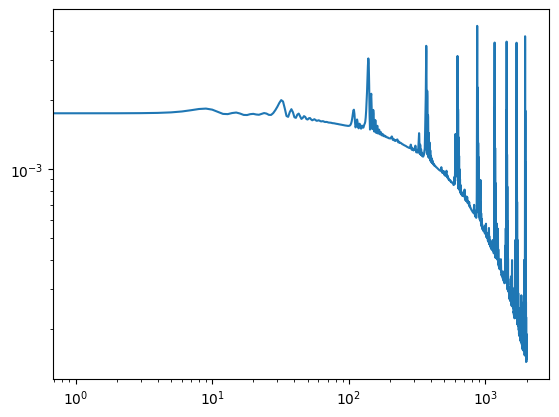

In [28]:
plt.loglog(losses)

In [29]:
mblocks = model.forward()
rmat = {}
for s in model.cell_shifts:
    rmat[tuple(s)] = _to_matrix(_to_uncoupled_basis(mblocks[tuple(s)]), frames = frames, orbitals=orbs,  NH=True)  # DONT FORGET NH=True      


/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/my_mlelec/src/mlelec/utils/metatensor_utils.py:129: DeviceWarning: Values and labels for this block are on different devices: labels are always on CPU, and values are on device 'cuda:0'. If you are using PyTorch and need the labels to also be on cuda:0, you should use `metatensor.torch.TensorBlock`.
  block = TensorBlock(
/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/my_mlelec/src/mlelec/utils/metatensor_utils.py:91: DeviceWarning: Blocks values and keys for this TensorMap are on different devices: keys are always on CPU, and blocks values are on device 'cuda:0'. If you are using PyTorch and need the labels to also be on cuda:0, you should use `metatensor.torch.TensorMap`.
  return TensorMap(keys, blocks)


In [37]:
mdict = {"mdict": model.state_dict(), "optimizer": optimizer.state_dict(), "epoch":4000}

In [38]:
torch.save(mdict, "rotated_model.pt")

In [30]:
# error on individual translations
for translation in model.cell_shifts: 
    print(translation, torch.linalg.norm(rmat[tuple(translation)]-matrices[tuple(translation)]).detach().cpu().numpy())

[1, 1, 0] 0.004570793010892625
[1, -2, 0] 0.005265318791018532
[1, -1, 0] 0.002152167003790616
[1, 0, 0] 0.0024277321396065942
[-2, 1, 0] 0.006987371963764007
[-2, -2, 0] 0.0020260091701494475
[-2, -1, 0] 0.0018207808010117148
[-2, 0, 0] 0.0027619864360295876
[-1, -2, 0] 0.0010077719040180791
[0, 1, 0] 0.0034215346115346206
[0, -2, 0] 0.0020534574684471134
[0, 0, 0] 0.004052818101030509


In [1]:
fig, ax, mappable = plot_hamiltonian((matrices[(0,1,0)]).detach().cpu()[0], plot_abs = True)
fig.colorbar(mappable, ax=ax)
fig.tight_layout()
# fig.savefig('/home/nigam/act010.png', dpi = 400, bbox_inches = 'tight')

NameError: name 'plot_hamiltonian' is not defined

## TODO: try diff loss functions 

In [ ]:
   
from typing import Union, List
def loss_zero_shift(pred, target, device=None):
    if device is None: 
        device = next(iter(pred.values())).device
    assert pred.keys() == target.keys()
    loss = 0
    
    loss += torch.sum((pred[tuple(s)]-target[tuple(s)])**2)
    return loss

def loss_fn_indiv_shift(rmat, matrices, specific_shift_idx:Union[str, List]=None, device=None):
    #TODO: loss over particular shifts
    if device is None: 
        device = rmat[(0,0,0)].device 

    #weight_minus = 1; weight_plus = 1 # we could still keep this?  
    if not isinstance(next(iter(matrices.values())), torch.Tensor):
        matrices = {k:torch.from_numpy(v).type(torch.float).to(device) for k,v in matrices.items()}
    loss = 0
    if isinstance(specific_shift_idx, list) or isinstance(specific_shift_idx,str):
        raise NotImplementedError
    # elif isinstance(specific_shift_idx, str):
    #     if specific_shift_idx == "positive":
    #         weight_minus=0
    #     elif specific_shift_idx == "negative":
    #         weight_plus=0
           
    for s in rmat.keys():            
        loss += torch.linalg.norm(rmat[s]-matrices[tuple(s)])**2

    return loss


def loss_fn_combined(rsum, rdiff, expkL:dict, complex_target, device = None):
    #TODO : support multiple k points 
    if device is None: 
        device = next(iter(rsum.values())).device
        complex_target = complex_target.to(device)
    assert rsum.keys() == rdiff.keys()
    matrix = {}
    for s in rsum.keys():
        matrix[tuple(s)] = rsum[tuple(s)] + rdiff[tuple(s)]
        matrix[tuple(-np.array(s))] = rsum[s] - rdiff[s]

    recon_target = torch.zeros_like(complex_target, requires_grad=True, dtype = torch.complex64, device = device)
    for s in matrix.keys():
         recon_target = recon_target+ matrix[s]*expkL[s]
    
    loss = torch.tensordot((recon_target-complex_target),torch.conj(recon_target-complex_target)) 
    # equivalent to torch.linalg.norm((recon_target-complex_target))**2
    assert torch.isclose(abs(loss), abs(loss.real))
    return loss.real

def get_predicted_matrices(rsum, rdiff, device=None):
    if device is None: 
        device = next(iter(rsum.values())).device
    assert rsum.keys() == rdiff.keys(), "rsum and rdiff must have same keys"
    matrix = {}
    for s in rsum.keys():
        # sint = [int(x) for x in s[1:-1].split(", ")]
        matrix[s] = rsum[s] + rdiff[s]
        matrix[tuple(-np.array(s))] = rsum[s] - rdiff[s]

    return matrix


In [ ]:
model = LinearModelPeriodic(hfeat, target, frames, orbs,
                            cell_shifts= withnegative_shifts, 
                            nhidden=16, nlayers=2)


In [ ]:

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# optimizer= torch.optim.SGD(model.parameters(), lr=1e-3)
# optimizer = torch.optim.LBFGS(model.parameters(), lr=1e-4)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=100, verbose=True)
def closure():
    optimizer.zero_grad()
    rmat = model.forward()
    loss = loss_fn_indiv_shift(rmat, matrices )
    loss.backward()
    return loss

losses = []
for i in range(1300):
    # loss = closure()
    # optimizer.step(closure)

    optimizer.zero_grad()
    rmat = model.forward()
    loss = loss_fn_indiv_shift(rmat, matrices) #, specific_shift_idx = 'positive' )
    loss.backward()
    optimizer.step()
    # scheduler.step(loss)
    losses.append(loss.item())
    if i%1 ==0:
        print(i, loss.item())


/tmp/ipykernel_92716/37171875.py:44: DeviceWarning: Values and labels for this block are on different devices: labels are always on CPU, and values are on device 'cuda:0'. If you are using PyTorch and need the labels to also be on cuda:0, you should use `metatensor.torch.TensorBlock`.
  pred_blocks.append(TensorBlock(values=pred.reshape((nsamples, ncomp, 1)),samples=block.samples,
/tmp/ipykernel_92716/37171875.py:49: DeviceWarning: Blocks values and keys for this TensorMap are on different devices: keys are always on CPU, and blocks values are on device 'cuda:0'. If you are using PyTorch and need the labels to also be on cuda:0, you should use `metatensor.torch.TensorMap`.
  pred_tmap = TensorMap(self.target_blocks.keys, pred_blocks)
/tmp/ipykernel_92716/37171875.py:67: DeviceWarning: Values and labels for this block are on different devices: labels are always on CPU, and values are on device 'cuda:0'. If you are using PyTorch and need the labels to also be on cuda:0, you should use `m

0 15.795816421508789
1 166.77407836914062
2 24.705739974975586
3 45.38225173950195
4 89.55624389648438


Exception ignored on calling ctypes callback function: <function ArrayWrapper.__init__.<locals>.mts_array_origin at 0x7f994462f880>
Traceback (most recent call last):
  File "/home/nigam/miniconda3/lib/python3.11/site-packages/metatensor/utils.py", line 30, in inner
    @functools.wraps(function)

KeyboardInterrupt: 


MetatensorError: invalid parameter: tried to build a TensorMap from blocks with different origins: at least ('metatensor.data.array.torch') and ('unregistered origin') were detected

## band structure